# Models

When binary = False, the Perceptual model
uses continuous outcomes (such as seen in exp. 3, partial destroy) to infer slope, given spaceship estimates given by the Value model.

In [113]:
import numpy as np
from scipy.stats import gamma, norm
# get truncated gamma and normal distributions
from scipy.stats import truncnorm
# from truncnorm get gamma and normal distributions


class SlopeMAPPerceptual:
    def __init__(self, *args, **kwargs):
        # Leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 9).round(2))
        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))
        
        # Initialize outcome-based prior
        # Slope prior mean and standard deviation
        self.slope_prior_mean = kwargs.get('slope_prior_mean', 0.0)  # Default mean to 0
        self.slope_prior_std = kwargs.get('slope_prior_std', 1.0)    # Default std to 1.0
        
        # Ensure the prior standard deviation is positive
        self.slope_prior_std = max(0.001, self.slope_prior_std)  # Set a minimum value
        
        # Possible values for the slope
        self.slope_range = kwargs.get('slope_range', np.arange(-10, 10, 0.1))
        
        # Initialize log-posterior for the slope with prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, self.slope_prior_mean, self.slope_prior_std))
        
        # Define logit function
        self.logit = lambda x: 1 / (1 + np.exp(x))

        self.binary = kwargs.get('binary', True)
        
    def perceptual_update(self, choice, outcome, spaceship_estimate=None):
        """Update the log-posterior of the slope based on observed data."""
        if self.binary:
            v = self.slope_range * choice
            v = v - v * 2 * outcome  # Switch to negative if forcefield destroyed
    
            # Binary outcome likelihood
            ll = np.log(self.logit(v))
        else:
           # Continuous outcome: outcome = sigmoid(slope * x) * spaceship reward
            logits = self.slope_range * choice

            # logistic probabilities
            p = self.logit(logits)

            # in the generative process of exp. 3, spaceship rewards is
            # multiplied by shield value to produce an outcome
            # Use observed outcome and estimated spaceship to derive implied sigmoid output
            pred_outcomes = np.clip(outcome / spaceship_estimate, 1e-6, 1 - 1e-6)

            # gaussian likelihood: compare each pred_outcome to the obtained outcome
            likelihoods = np.exp(-0.5 * ((p-pred_outcomes) ** 2) / 0.1)

            # posterior
            posterior = likelihoods / np.sum(likelihoods)

            ll = np.log(posterior)

        # Update log posterior
        self.lp_slope += ll
           
    def predict_shield_p(self, shields):
        """Predict outcomes (linear or logit) for given forcefields."""
        # Predict for 2 displayed forcefields
        x = np.arange(len(self.x))
        to_select = x[np.isin(self.x, shields)]
        return self.logit(self.get_slope() * self.x[to_select])
    
    def get_slope(self):
        """Compute the current slope as the weighted mean of the slope range."""
        w = np.exp(self.lp_slope - np.max(self.lp_slope))
        slope = np.sum(w * self.slope_range) / np.sum(w)
        return slope

class NormativePerceptual:
    def __init__(self, prior_mean=[0, 0], prior_cov=[[1, 0], [0, 1]], burn_in=500, samples=1000):
        """
        Bayesian Probit Model using Gibbs sampling.
        
        Parameters:
            prior_mean : list of prior means [β, α]
            prior_cov : prior covariance matrix (2x2)
            burn_in : number of burn-in samples
            samples : number of posterior samples after burn-in
        """
        self.m0 = np.array(prior_mean)
        self.S0 = np.array(prior_cov)
        self.burn_in = burn_in
        self.samples = samples
        self.theta_samples = []  # to store (β, α) samples
        
    def perceptual_update(self, z, b):
        """
        Perform Gibbs sampling given data.

        Parameters:
            z : 1D numpy array of shield strengths
            b : 1D numpy array of binary outcomes (0 or 1)
        """
        n = len(z)
        Z = np.column_stack((np.ones(n), z))  # Design matrix
        theta = np.random.multivariate_normal(self.m0, self.S0)  # Initial guess for (β, α)

        all_samples = []

        for t in range(self.burn_in + self.samples):
            # Step 1: sample latent u
            eta = Z @ theta
            u = np.zeros(n)

            for i in range(n):
                if b[i] == 1:
                    a, b_ = (0 - eta[i]), np.inf
                else:
                    a, b_ = -np.inf, (0 - eta[i])
                u[i] = truncnorm.rvs(a, b_, loc=eta[i], scale=1)

            # Step 2: sample (β, α)
            S_post_inv = np.linalg.inv(self.S0) + Z.T @ Z
            S_post = np.linalg.inv(S_post_inv)
            m_post = S_post @ (np.linalg.inv(self.S0) @ self.m0 + Z.T @ u)
            theta = np.random.multivariate_normal(m_post, S_post)

            if t >= self.burn_in:
                all_samples.append(theta)

        self.theta_samples = np.array(all_samples)
        
    def perceptual_update2(self, z, b):
        """
        Perform Gibbs sampling given data.

        Parameters:
            z : 1D numpy array of shield strengths
            b : 1D numpy array of binary outcomes (0 or 1)
        """
        n = len(z)
        Z = np.column_stack((np.ones(n), z))  # Design matrix
        theta = np.random.multivariate_normal(self.m0, self.S0)  # Initial guess for (β, α)

        all_samples = []
                # Pre-calculate constant terms
        S0_inv = np.linalg.inv(self.S0)
        ZtZ = Z.T @ Z
        S0_inv_m0 = S0_inv @ self.m0

        for t in range(self.burn_in + self.samples):
            # Step 1: sample latent u
            eta = Z @ theta
            # Vectorized sampling of u
            idx_b1 = (b == 1)
            idx_b0 = (b == 0)

            a_bounds = np.full(n, -np.inf)
            b_bounds = np.full(n, np.inf)

            a_bounds[idx_b1] = -eta[idx_b1]
            b_bounds[idx_b0] = -eta[idx_b0]

            u = truncnorm.rvs(a_bounds, b_bounds, loc=eta, scale=1)

            # Step 2: sample (β, α)
            # Step 2: sample (β, α)
            S_post_inv = S0_inv + ZtZ  # Use pre-calculated terms            
            S_post = np.linalg.inv(S_post_inv)
          
            m_post = S_post @ (S0_inv_m0 + Z.T @ u) # Use pre-calculated S0_inv @ m0
            theta = np.random.multivariate_normal(m_post, S_post)


            if t >= self.burn_in:
                all_samples.append(theta)

        self.theta_samples = np.array(all_samples)

    def perceptual_update3(self, z, b):
        """
        Perform Gibbs sampling given data with a fallback for small sample sizes
        or invalid truncation bounds.

        Parameters:
            z : 1D numpy array of shield strengths
            b : 1D numpy array of binary outcomes (0 or 1)
        """
        if self.model == 'value':
            return 
        
        n = len(z)
        Z = np.column_stack((np.ones(n), z))  # Design matrix
        theta = np.random.multivariate_normal(self.m0.ravel(), self.S0)  # Initial guess for (β, α)

        all_samples = []

        # Pre-calculate constant terms
        S0_inv = np.linalg.inv(self.S0)
        ZtZ = Z.T @ Z
        S0_inv_m0 = S0_inv @ self.m0

        for t in range(self.burn_in + self.samples):
            # Step 1: sample latent u
            eta = Z @ theta
            a_bounds = np.full(n, -np.inf)
            b_bounds = np.full(n, np.inf)

            # Adjust bounds based on b
            a_bounds[b == 1] = -eta[b == 1]
            b_bounds[b == 0] = -eta[b == 0]

            # Safe sampling with fallback for small n or invalid bounds
            fallback = n < 10 or np.any(a_bounds > b_bounds)
            if fallback:
                u = np.zeros(n)
                for i in range(n):
                    a, b_ = a_bounds[i], b_bounds[i]
                    if a > b_:
                        raise ValueError(f"Invalid truncation bounds at index {i}: a > b")
                    u[i] = truncnorm.rvs(a, b_, loc=eta[i], scale=1)
            else:
                u = truncnorm.rvs(a_bounds, b_bounds, loc=eta, scale=1)

            # Step 2: sample (β, α)
            S_post_inv = S0_inv + ZtZ
            S_post = np.linalg.inv(S_post_inv)
            m_post = S_post @ (S0_inv_m0 + Z.T @ u)
            theta = np.random.multivariate_normal(m_post, S_post)

            if t >= self.burn_in:
                all_samples.append(theta)

        self.theta_samples = np.array(all_samples)


    def predict_shield_p(self, shield):
        """
        Compute predictive probability p(b=1 | z) using posterior samples.

        Parameters:
            shield : scalar value (z*)

        Returns:
            Posterior predictive probability for that shield strength.
        """
        if self.model == 'value':
            return 1.0
        if len(self.theta_samples) == 0:
            raise ValueError("You must run perceptual_update() first.")
        

        β = self.theta_samples[:, 0]
        α = self.theta_samples[:, 1]
        preds = norm.cdf(β + α * shield)
        return preds.mean()

class NormativeValue:
    def __init__(self, spaceship_ids, mu0=.5, kappa0=1, alpha0=2, beta0=0.1):
        """
        Bayesian reward model using Normal-Gamma conjugate prior for multiple spaceships.

        Parameters:
            spaceship_ids : list of spaceship identifiers (ints or strings)
            mu0, kappa0, alpha0, beta0 : prior hyperparameters for all spaceships
        """
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0

        self.data = {sid: [] for sid in spaceship_ids}

    def value_update(self, spaceship_id, reward):
        """
        Add an observed reward for a specific spaceship.

        Parameters:
            spaceship_id : ID of the spaceship
            reward : observed scalar reward
        """
        if spaceship_id not in self.data:
            raise ValueError(f"Unknown spaceship ID: {spaceship_id}")
        self.data[spaceship_id].append(reward)

    def compute_posterior(self, spaceship_id):
        """
        Compute the posterior parameters for a given spaceship.
        """
        if self.model == 'perceptual':
            return 
            
        xi = np.array(self.data[spaceship_id])
        n = len(xi)

        if n == 0:
            return self.mu0, self.kappa0, self.alpha0, self.beta0

        x_bar = xi.mean()
        S = np.sum((xi - x_bar) ** 2)

        kappa_n = self.kappa0 + n
        mu_n = (self.kappa0 * self.mu0 + n * x_bar) / kappa_n
        alpha_n = self.alpha0 + n / 2
        beta_n = self.beta0 + 0.5 * S + (self.kappa0 * n * (x_bar - self.mu0) ** 2) / (2 * kappa_n)

        return mu_n, kappa_n, alpha_n, beta_n

    def posterior_predictive_mean(self, spaceship_id):
        """
        Return the expected value (mean) of the predictive distribution for a spaceship.
        """
        if self.model == 'perceptual':
            return 1.0
        mu_n, _, _, _ = self.compute_posterior(spaceship_id)
        return mu_n

    def sample_posterior(self, spaceship_id, n_samples=1000):
        """
        Sample possible mean rewards for a spaceship from the posterior predictive distribution.
        """
        mu_n, kappa_n, alpha_n, beta_n = self.compute_posterior(spaceship_id)

        tau_samples = gamma.rvs(a=alpha_n, scale=1 / beta_n, size=n_samples)
        mu_samples = norm.rvs(loc=mu_n, scale=1 / np.sqrt(kappa_n * tau_samples))
        #truncated normal distribution
        mu_samples = truncnorm.rvs(a=0, b=1, loc=mu_samples, scale=1 / np.sqrt(kappa_n * tau_samples))

        return mu_samples

    def reset(self, spaceship_id=None):
        """
        Reset observations for one or all spaceships.
        """
        if spaceship_id is None:
            for sid in self.data:
                self.data[sid] = []
        else:
            self.data[spaceship_id] = []

class NormativePolicy(NormativeValue):
    def __init__(self, spaceship_ids, mu0=.5, kappa0=1, alpha0=2, beta0=0.1,
                 burn_in=500, samples=1000, model=False, omega=0, beta=1, binary=True):
        NormativeValue.__init__(self, spaceship_ids, mu0, kappa0, alpha0, beta0)
        if model == 'gibbs':
            print('model is gibbs')
            self.perceptual = NormativePerceptual(burn_in=burn_in, samples=samples)
            self.perceptual.model = 'gibbs'
        else:
            # print('model is map')
            self.perceptual = SlopeMAPPerceptual(binary=binary)
            self.perceptual.model = 'map'
        self.perceptual_update = self.perceptual.perceptual_update
        self.predict_shield_p = self.perceptual.predict_shield_p
        self.get_slope = self.perceptual.get_slope
        
        self.omega = omega
        self.beta = beta
        self.model = model
        self.v_log_ratio_list = []
        self.p_log_ratio_list = []
        self.v_log_ratio = 0
        self.p_log_ratio = 0

    def expected_reward(self, spaceship_id, shield_strength):
        """
        Compute the expected reward for a spaceship given a shield strength z

        Parameters:
            spaceship_id : spaceship ID
            shield_strength : scalar z*

        Returns:
            Expected reward E[Y | z*, Z, B, X]
        """
        # Step 1: compute P(b=1 | z*) from probit model
        p_success = 1.0  # Default if no shield strength is provided
        if ~np.isnan(shield_strength) and self.model != 'value':
            p_success = self.perceptual.predict_shield_p(shield_strength)

        # Step 2: compute E[μ | X] from reward model
        E_mu = 1.0 
        if self.model != 'perceptual':
            mu_n, kappa_n, _, _ = self.compute_posterior(spaceship_id)
            E_mu = mu_n

        # Step 3: combine both
        return p_success, E_mu

    def get_spaceship_mean(self, spaceship_id):
        E_mu = 1.0
        if self.model != 'perceptual':
            mu_n, kappa_n, _, _ = self.compute_posterior(spaceship_id)
            E_mu = mu_n
        return E_mu
    
    def get_shield_probability(self, shield_strength):
        p_success = 1.0
        if ~np.isnan(shield_strength) and self.model != 'value':
            p_success = self.perceptual.predict_shield_p(shield_strength)
        return p_success

    def choose(self, spaceships, shields):
        """
        compute the expected reward for a spaceship given a shield strength z
        and select the one that tends to maximize it.
        """

        p1, p2 = [self.get_shield_probability(x) for x in shields]
        v1, v2 = [self.get_spaceship_mean(x) for x in spaceships]
    
        v_lr = np.log(v1) - np.log(v2)
        p_lr = np.log(p1) - np.log(p2)

        self.v_log_ratio_list.append(v_lr)  
        self.p_log_ratio_list.append(p_lr)

        # v_lr = v_lr / 0.59
        # p_lr = p_lr / 0.74        
        
        dv = (1-self.omega) * v_lr + self.omega * p_lr

        return int(np.random.random() > (1/(1 + np.exp(self.beta*-dv))))
    
    def get_likelihood(self, spaceships, shields):
        """
        computes the likelihood of both options
        given the shield strengths and  spaceships
        """

        p1, p2 = [self.get_shield_probability(x) for x in shields]
        v1, v2 = [self.get_spaceship_mean(x) for x in spaceships]
    
        v_lr = np.log(v1) - np.log(v2)
        p_lr = np.log(p1) - np.log(p2)

        # v_lr = v_lr / 0.59
        # p_lr = p_lr / 0.74        
        
        dv = (1-self.omega) * v_lr + self.omega * p_lr

        # estimated p of choosing option 1
        ep1 = 1/(1 + np.exp(self.beta*-dv))

        return [ep1, 1-ep1]
        
        
    def choose2(self, spaceships, shields):
        """
        compute the expected reward for a spaceship given a shield strength z
        and select the one that tends to maximize it.
        """

        p1, p2 = [self.get_shield_probability(x) for x in shields]
        v1, v2 = [self.get_spaceship_mean(x) for x in spaceships]
    
        self.v_log_ratio = np.log(v1) - np.log(v2)
        self.p_log_ratio = np.log(p1) - np.log(p2)

        # # v_lr = v_lr / np.std(self.v_log_ratio_list)
        # # p_lr = p_lr / np.std(self.p_log_ratio_list)

        # dv = (1-self.omega) * v_lr + self.omega * p_lr

        # return int(np.random.random() > (1/(1 + np.exp(self.beta*-dv))))
        
        # # not a dic now but two arrays
        expected_rewards = [
            sid*shield
            for sid, shield in zip([v1, v2], [p1, p2])
        ]
        return np.argmax(expected_rewards)

        #best_id = max(expected_rewards, key=expected_rewards.get)
        


In [89]:
import numpy as np
from scipy.stats import gamma, norm
from scipy.stats import truncnorm


class Perceptual:
    def __init__(self, *args, **kwargs):
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 9).round(2))
        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))

        # Slope prior mean and standard deviation
        self.slope_prior_mean = kwargs.get('slope_prior_mean', 0.0)  # Default mean to 0
        self.slope_prior_std = kwargs.get('slope_prior_std', 1.0)    # Default std to 1.0

        # Ensure the prior standard deviation is positive
        self.slope_prior_std = max(0.001, self.slope_prior_std)  # Set a minimum value

        # Possible values for the slope
        self.slope_range = kwargs.get('slope_range', np.arange(-10, 10, 0.1))

        # Initialize log-posterior for the slope with prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, self.slope_prior_mean, self.slope_prior_std))

        # Define logit function
        self.logit = lambda x: 1 / (1 + np.exp(x))
        self.binary = kwargs.get('binary', False)

    def perceptual_update(self, choice, outcome, spaceship_estimate):
        """Update the log-posterior of the slope based on observed data."""
        if self.binary:
            # Binary outcome: use Bernoulli likelihood (e.g., logistic model)
            #outcome = binomial(1, p, 1)
            v = self.slope_range * choice
            v = v - v * 2 * outcome  # Switch to negative if shield destroyed
            # Binary outcome likelihood
            ll = np.log(self.logit(v))
        else:
            # Continuous outcome: outcome = sigmoid(slope * x) * spaceship reward
            logits = self.slope_range * choice

            # logistic probabilities
            p = self.logit(logits)

            # in the generative process of exp. 3, spaceship rewards is
            # multiplied by shield value to produce an outcome
            # Use observed outcome and estimated spaceship to derive implied sigmoid output
            pred_outcomes = np.clip(outcome / spaceship_estimate, 1e-6, 1 - 1e-6)

            # gaussian likelihood: compare each pred_outcome to the obtained outcome
            likelihoods = np.exp(-0.5 * ((p-pred_outcomes) ** 2) / 0.45 ** 2)

            # posterior
            posterior = likelihoods / np.sum(likelihoods)

            ll = np.log(posterior)

        # Update log posterior
        self.lp_slope += ll

    def predict_shield_p(self, shields):
        """Predict outcomes for given shields."""
        # Predict for 2 displayed forcefields
        x = np.arange(len(self.x))
        to_select = x[np.isin(self.x, shields)]
        return self.logit(-self.get_slope() * self.x[to_select])

    def get_slope(self):
        """Compute the current slope as the weighted mean of the slope range."""
        w = np.exp(self.lp_slope - np.max(self.lp_slope))
        slope = np.sum(w * self.slope_range) / np.sum(w)
        return slope


class Value:
    def __init__(self, spaceship_ids, mu0=.5, kappa0=1, alpha0=2, beta0=0.1):
        """
        Bayesian reward model using Normal-Gamma conjugate prior for multiple spaceships.

        Parameters:
            spaceship_ids : list of spaceship identifiers (ints or strings)
            mu0, kappa0, alpha0, beta0 : prior hyperparameters for all spaceships
        """
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.model = None

        self.data = {sid: [] for sid in spaceship_ids}

    def value_update(self, spaceship_id, reward):
        """
        Add an observed reward for a specific spaceship.

        Parameters:
            spaceship_id : ID of the spaceship
            reward : observed scalar reward
        """
        if spaceship_id not in self.data:
            raise ValueError(f"Unknown spaceship ID: {spaceship_id}")
        self.data[spaceship_id].append(reward)

    def compute_posterior(self, spaceship_id):
        """
        Compute the posterior parameters for a given spaceship.
        """
        xi = np.array(self.data[spaceship_id])
        n = len(xi)

        if n == 0:
            return self.mu0, self.kappa0, self.alpha0, self.beta0

        x_bar = xi.mean()
        S = np.sum((xi - x_bar) ** 2)

        kappa_n = self.kappa0 + n
        mu_n = (self.kappa0 * self.mu0 + n * x_bar) / kappa_n
        alpha_n = self.alpha0 + n / 2
        beta_n = self.beta0 + 0.5 * S + (self.kappa0 * n * (x_bar - self.mu0) ** 2) / (2 * kappa_n)

        return mu_n, kappa_n, alpha_n, beta_n

    def posterior_predictive_mean(self, spaceship_id):
        """
        Return the expected value (mean) of the predictive distribution for a spaceship.
        """
        mu_n, _, _, _ = self.compute_posterior(spaceship_id)
        return mu_n

    def sample_posterior(self, spaceship_id, n_samples=1000):
        """
        Sample possible mean rewards for a spaceship from the posterior predictive distribution.
        """
        mu_n, kappa_n, alpha_n, beta_n = self.compute_posterior(spaceship_id)

        tau_samples = gamma.rvs(a=alpha_n, scale=1 / beta_n, size=n_samples)
        mu_samples = norm.rvs(loc=mu_n, scale=1 / np.sqrt(kappa_n * tau_samples))
        #truncated normal distribution
        mu_samples = truncnorm.rvs(a=0, b=1, loc=mu_samples, scale=1 / np.sqrt(kappa_n * tau_samples))

        return mu_samples

    def reset(self, spaceship_id=None):
        """
        Reset observations for one or all spaceships.
        """
        if spaceship_id is None:
            for sid in self.data:
                self.data[sid] = []
        else:
            self.data[spaceship_id] = []


# Run simulations

In [50]:
true_slope = -2

# ~ our testing phase length
n_trials = 1000

rewards = np.array([0.28, 0.38, 0.62, 0.72])

# Simulate data
# spaceship ids presented
spaceships = [1,2,3,4]
ss_ids = np.random.choice(spaceships, size=n_trials)
# associated reward sequence
r_seq = rewards[ss_ids - 1]

# shields strength between -1 and 1
shields = np.random.choice(np.linspace(-1, 1, 9).round(2), size=n_trials)
# true probabilities associated to the shields sequence
p_true = 1 / (1 + np.exp(true_slope * shields))

# outcomes obtained
outcomes = p_true * (r_seq + np.random.normal(0, 0.02, size=n_trials))

# Initialize and update model
# vmodel = Value(spaceship_ids=[1, 2, 3, 4])
# pmodel = Perceptual(binary=False)
model = NormativePolicy(spaceship_ids=[1, 2, 3, 4], model='map', binary=False)
slopes = []
means = np.zeros((len(rewards), n_trials))

for t in range(n_trials):
    model.value_update(spaceship_id=ss_ids[t], reward=outcomes[t])
    rews = np.array([model.posterior_predictive_mean(x) for x in spaceships])

    model.perceptual_update(shields[t], outcomes[t], rews[ss_ids[t] - 1])
    means[:, t] = rews
    slopes.append(model.get_slope())



 # Plot perceptual slope

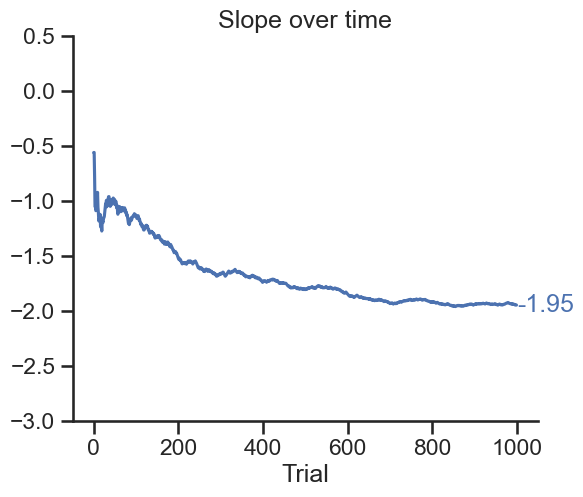

In [51]:
# plot overtime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set({'figure.figsize': (6, 5)})
sns.set_style('ticks')
sns.set_context('talk')

sns.lineplot(x=np.arange(n_trials), y=slopes)
plt.text(n_trials, slopes[-1], f'{slopes[-1]:.2f}', ha='left', va='center', color='C0')
plt.title('Slope over time')
plt.xlabel('Trial')
plt.ylim(-3, 0.5)

sns.despine()

# Plot spaceship estimates

NB: the "real" value  learned internally is the one plotted below divided by 2, because in the generative process reward was multiplied by a shield of value .5 on average

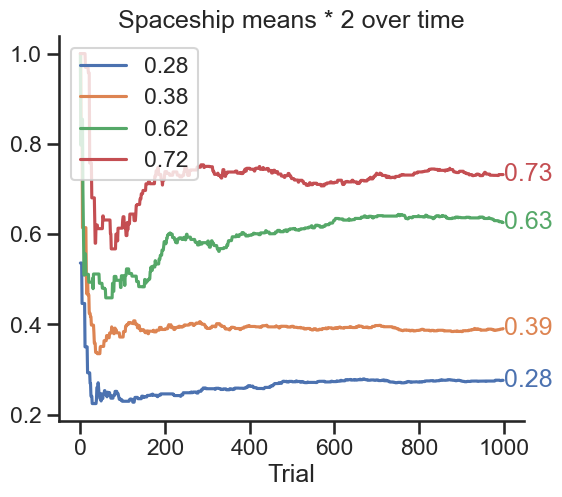

In [52]:
sns.set({'figure.figsize': (6, 5)})
sns.set_style('ticks')
sns.set_context('talk')

# means over time
for i in range(len(rewards)):
    sns.lineplot(x=np.arange(n_trials), y=means[i, :]*2, label=rewards[i])
    # plot the mean at the end (last trial mean)
    # with text
    plt.text(n_trials, means[i, -1]*2, f'{means[i, -1]*2:.2f}', ha='left', va='center', color=f'C{i}')

plt.title('Spaceship means * 2 over time')
plt.xlabel('Trial')
sns.despine()

# With real data

In [78]:

import seaborn as sns
# import sys
# sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('../data/raw/fullpilot13_22.csv')
df2 = pd.read_csv('../data/raw/fullpilot1466.csv')


df2 = df2[df2.expName.isin(['FullPilot14'])]
df = df[df.expName.isin(['FullPilot13', 'FullPilot12'])]

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
df2 = df2[df2.prolificID.str.len() > 10]
# show prolificIDs 

df = pd.concat([df, df2])
df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14'])]

df = df[df.session.isin([0, 1, 2, 3])]

# Adjust `t` to be cumulative across sessions
# Compute the number of trials in each session
session_counts = df.groupby('session')['t'].max() + 1

# Compute the cumulative starting points for each session
cumulative_starts = session_counts.cumsum().shift(fill_value=0)

# Map each session to its starting point and adjust `t`
df['t'] = df['t'] + df['session'].map(cumulative_starts)

df = df[df.choice.isin([1, 2])]
# df = df[df.pair.isin([0,1])]
df.loc[df.expName=='FullPilot14', 'destroyed'] = 1

df['ev1'] = df.p1 * df.m1
df['ev2'] = df.p2 * df.m2
df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['opti_ev'] = (df.ev1 >= df.ev2) & (df.choice == 1) | (df.ev2 >= df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)

df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)
df['outcome'] /= 1000
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
# df['trial'] = ((df.t.max()+1) * (df.session-2)) + df.t
df['trial'] = df.t
df['s'] = list(zip(df.m1, df.m2))

print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

# df['pair'] = df.pair.apply(lambda x: 0 if x < 0 else x)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
map_ff_values[1] = 1
df['agent'] = df.prolificID

df['s'] = list(zip(df.m1, df.m2))
df['a'] = (df.choice - 1).astype(int)  # Convert choice to 1 or 0
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
# if (df.p1.unique()[0]==1):
    # df['ff1'] = .25
    # df['ff2'] = .25
df['destroy'] = df.destroyed





Number of participants: 190


In [6]:
df.groupby('prolificID').size()

prolificID
5484a2b2fdf99b07b28f2335    316
5484d361fdf99b0379939d5b    315
559c3a4dfdf99b32b6963e70    316
57027c1f68c641000e0c8970    316
57bb618b8e26d6000196c3bb    314
                           ... 
675efe6044b2f5bde425ceac    315
67603ec6f369599a362eecb9    316
67628f7b4f57e91918c49e72    305
677a58735c4ac72aaffc95a7    316
677b177da6c75e1c1a0d8c5f    314
Length: 190, dtype: int64

In [129]:
df.t.max()

315

In [ ]:
df.groupby('prolificID').t.max

In [109]:
df = df[(df.expName=='FullPilot14')].sort_values('t')
df = df[df.session==3]

# only take first 172 trials in session 3 for each participant
df = df.groupby('prolificID').head(315).reset_index(drop=True)

true_slope = -2
nsub = df.prolificID.nunique()

slopes = []
means = []

data = []
for prolificID in df.prolificID.unique():
    df2 = df[df.prolificID == prolificID].sort_values('t')
    n_trials = df2.shape[0]
    rewards = np.array([0.28, 0.38, 0.5, 0.62, 0.72])


    # shields strength between -1 and 1
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    # true probabilities associated to the shields sequence
    p_true = 1 / (1 + np.exp(true_slope * shields))

    # outcomes obtained
    outcomes = df2.outcome.values
    outcomes1 = df2.outcome1.values
    outcomes2 = df2.outcome2.values
    choice = df2.choice.values
    session = df2.session.values
    ev1 = df2.ev1.values
    ev2 = df2.ev2.values

    # Initialize and update model
    # vmodel = Value(spaceship_ids=[280, 380, 500, 620, 720])
    # pmodel = Perceptual(binary=False)
    model = NormativePolicy(spaceship_ids=[280, 380, 500, 620, 720], model='map', binary=False, 
                            omega=0, beta=10)
    s = df2.s.values
    spaceships = [280, 380, 500, 620, 720]

    for t in range(len(outcomes)):

        # choice[t] = np.random.choice([1, 2], p=[0.5, 0.5])
        choice[t] = model.choose(s[t], [ff1[t], ff2[t]]) + 1
        outcomes[t] = outcomes1[t] if choice[t] == 1 else outcomes2[t]
        outcomes[t]/= 1000  # convert to 0-1 range
        if session[t] in (0, 2, 3):
            model.value_update(spaceship_id=s[t][choice[t]-1], reward=outcomes[t])
            rews = np.array([model.posterior_predictive_mean(x) for x in spaceships])

        if session[t] in (1, 3):
            # in session 0 and 2, we use the true values
            shield = ff1[t] if choice[t] == 1 else ff2[t]
            # as shield average value is .5, we provide the perceptual model
            # with estimates of spaceships value * 2
            if session[t] == 1:
                rews = np.array([0.5, 0.5, 0.5, 0.5, .5])
                model.perceptual_update(shield, outcomes[t], .5)
            else:
                model.perceptual_update(shield, outcomes[t], model.posterior_predictive_mean(s[t][choice[t]-1]))
        data.append({
            'id': df2.prolificID.values[0],
            'session': session[t],
            'trial': t,
            'shield': shield,
            'choice': choice[t],
            'outcome': outcomes[t],
            'slope': model.get_slope(),
            'ff1': ff1[t],
            'ff2': ff2[t],
            'opti_ev': (ev1[t] >= ev2[t]) & (choice[t] == 1) | (ev2[t] >= ev1[t]) & (choice[t] == 2),
            'opti_ff': (ff1[t] > ff2[t]) & (choice[t] == 1) | (ff2[t] > ff1[t]) & (choice[t] == 2),
            'opti_ss': (s[t][0] > s[t][1]) & (choice[t] == 1) | (s[t][1] > s[t][0]) & (choice[t] == 2),
        })
        
        # add means using loop to the dict in data
        data[-1].update({f'mean{i+1}': rews[i] for i in range(len(rews))})
        
        
        

data = pd.DataFrame(data)



C:\Users\basil\AppData\Local\Temp\ipykernel_18352\1636451845.py:424: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(np.random.random() > (1/(1 + np.exp(self.beta*-dv))))


In [81]:
df[df.session==1][['outcome1', 'outcome2', 'p1', 'p2', 'm1', 'm2', 'ev1', 'ev2', 'destroyed']].head()

,outcome1,outcome2,p1,p2,m1,m2,ev1,ev2,destroyed
3037,250,59,0.50,0.12,500,500,250.0,60.0,1
3038,439,365,0.88,0.73,500,500,440.0,365.0,1
3039,439,409,0.88,0.82,500,500,440.0,410.0,1
3040,439,90,0.88,0.18,500,500,440.0,90.0,1
3041,90,310,0.18,0.62,500,500,90.0,310.0,1


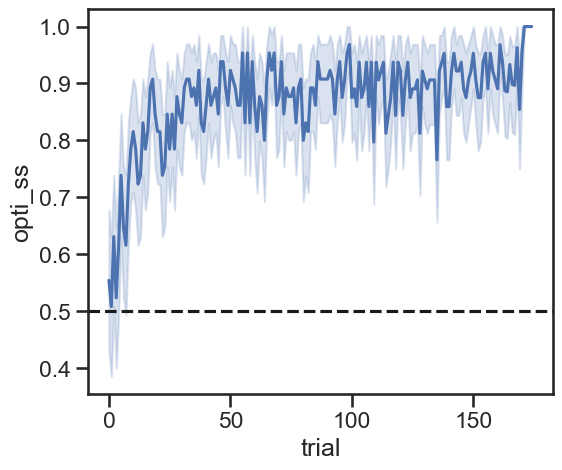

In [111]:
sns.lineplot(data=data, x='trial', y='opti_ss')
plt.axhline(y=0.5, color='k', linestyle='--')

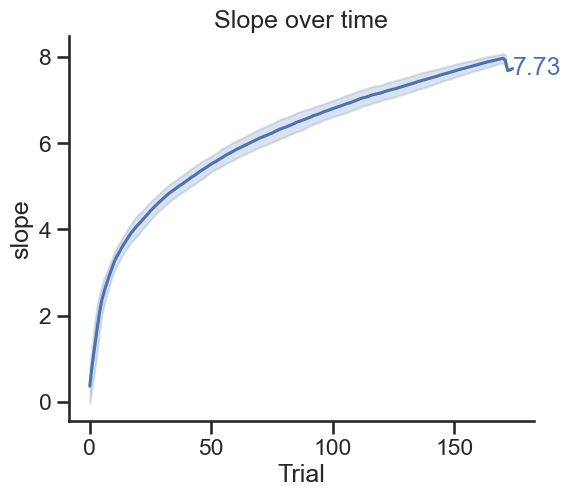

In [112]:
# plot overtime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set({'figure.figsize': (6, 5)})
sns.set_style('ticks')
sns.set_context('talk')

sns.lineplot(x='trial', y='slope', data=data, errorbar='sd')
plt.text(data.trial.max(), data[data.trial == data.trial.max()].slope.mean(),
          f'{data[data.trial == data.trial.max()].slope.mean():.2f}', ha='left', va='center', color='C0')
plt.title('Slope over time')
plt.xlabel('Trial')

sns.despine()

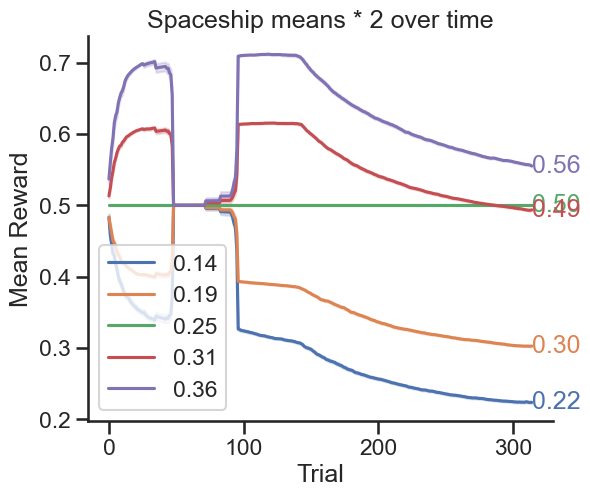

In [93]:
sns.set({'figure.figsize': (6, 5)})
sns.set_style('ticks')
sns.set_context('talk')

# data['mean1'] = data.mean1 * 2
# data['mean2'] = data.mean2 * 2
# data['mean3'] = data.mean3 * 2
# data['mean4'] = data.mean4 * 2
# means over time
for i in range(len(rewards)):
    sns.lineplot(x='trial', y=f'mean{i+1}', data=data, label=rewards[i]/2, errorbar='se')
    # plot the mean at the end (last trial mean)
    # with text
    plt.text(data.trial.max(), data[data.trial == data.trial.max()][f'mean{i+1}'].mean(), 
             f'{data[data.trial == data.trial.max()][f"mean{i+1}"].mean():.2f}', 
             ha='left', va='center', color=f'C{i}')
plt.title('Spaceship means * 2 over time')
plt.xlabel('Trial')
plt.ylabel('Mean Reward')
sns.despine()

In [ ]:
for m in [280, 380, 620, 720]:
    o = df[(df.m1 == m) & (df.choice == 1) | (df.m2 == m) & (df.choice == 2)].outcome.mean()
    o2 = df[df.m1 == m].outcome1.mean() 
    o2_2 = df[df.m2 == m].outcome2.mean()

    o2 = (o2 + o2_2) / 2 / 1000
    print(f'Mean outcome for spaceship {m/1000/2}: {o2:.2f}')
    print(f'Mean outcome for spaceship {m/1000/2} choice: {o:.2f}')

    # print(f'Mean outcome for spaceship {m}: {o2:.2f}')
    # print(f'Mean outcome for spaceship {m}: {o:.2f}')

Mean outcome for spaceship 0.14: 0.14
Mean outcome for spaceship 0.14 choice: 0.18
Mean outcome for spaceship 0.19: 0.20
Mean outcome for spaceship 0.19 choice: 0.25
Mean outcome for spaceship 0.31: 0.34
Mean outcome for spaceship 0.31 choice: 0.40
Mean outcome for spaceship 0.36: 0.37
Mean outcome for spaceship 0.36 choice: 0.45
